In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
import numpy as np
import pandas as pd
from keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, Input, MaxPooling1D

from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

from tensorflow.keras.optimizers import Adam

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 128
EPOCHS = 5

In [135]:
cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


In [136]:
train = pd.read_csv('train_clean_removed_emoticons.csv')
sentences = train["Review Text"].fillna("DUMMY_VALUE").values
possible_labels = list(set(train["Rating"]))
y = train["Rating"].values
targets = to_categorical(y)

In [137]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.add('dress')
stop_words.add('petite')
stop_words.add('jacket')
stop_words.add('blazer')

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ')           #1
    words = tokenizer.tokenize(txt)                   #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words]              #4 steming kad ubacimo daje losije rezultate
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [138]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()                             # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)       # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text)             # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
train['Cleaned_Review_Text'] = train['Review Text'].apply(clean_text)

In [139]:
new_str = [str(x) for x in train['Cleaned_Review_Text']]

df = pd.DataFrame(new_str)
temp = []
for i in range(len(df)):
  temp.append(preprocessing(df.iloc[i]))


In [140]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(temp)
sequences = tokenizer.texts_to_sequences(temp)
s = sorted(len(s) for s in sequences)
word2idx = tokenizer.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)

In [141]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
)

In [142]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# --------------------------------------
x = Conv1D(256, 3, activation="relu")(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation="relu")(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(possible_labels) + 1, activation="softmax")(x)

model = Model(input_, output)
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.01),
    metrics=["accuracy"],
)

In [143]:
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
)

Epoch 1/5
128/128 [==============================] - 3s 21ms/step - loss: 1.0764 - accuracy: 0.5724 - val_loss: 0.9205 - val_accuracy: 0.6131
Epoch 2/5
128/128 [==============================] - 2s 19ms/step - loss: 0.8728 - accuracy: 0.6338 - val_loss: 0.9043 - val_accuracy: 0.6225
Epoch 3/5
128/128 [==============================] - 2s 19ms/step - loss: 0.7472 - accuracy: 0.6849 - val_loss: 0.9834 - val_accuracy: 0.6214
Epoch 4/5
128/128 [==============================] - 2s 19ms/step - loss: 0.6490 - accuracy: 0.7308 - val_loss: 1.0481 - val_accuracy: 0.6181
Epoch 5/5
128/128 [==============================] - 2s 19ms/step - loss: 0.5505 - accuracy: 0.7723 - val_loss: 1.1529 - val_accuracy: 0.5944


In [144]:
p = model.predict(data)
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [145]:
print(confusion_matrix(y, y_pred))

[[ 430  157   42    8   20]
 [ 128  650  369   56   34]
 [  23  280 1463  377  118]
 [   5   27  200 2844  844]
 [   0    9   41  365 9623]]


In [146]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.65      0.69       657
           2       0.58      0.53      0.55      1237
           3       0.69      0.65      0.67      2261
           4       0.78      0.73      0.75      3920
           5       0.90      0.96      0.93     10038

    accuracy                           0.83     18113
   macro avg       0.74      0.70      0.72     18113
weighted avg       0.82      0.83      0.82     18113



In [147]:
print(f1_score(y, y_pred, average="micro"))

0.828686578700381


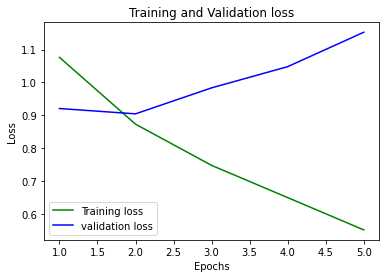

In [148]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

loss_train = r.history['loss']
loss_val = r.history['val_loss']
epochs = range(1,6)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Test**

In [149]:
test = pd.read_csv('test_clean_removed_emoticons.csv')
test_text = test["Review Text"].values
test_text = [str(x).lower() for x in test_text]

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

y_test = test["Rating"].values

In [150]:
p = model.predict(data)
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [151]:
print(confusion_matrix(y_test, y_pred))

[[  17   21   23    9   12]
 [  12   34   45   41   23]
 [  10   36   83   92   59]
 [   1   14   34  198  246]
 [   0   10   30  175 1038]]


In [152]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.42      0.21      0.28        82
           2       0.30      0.22      0.25       155
           3       0.39      0.30      0.34       280
           4       0.38      0.40      0.39       493
           5       0.75      0.83      0.79      1253

    accuracy                           0.61      2263
   macro avg       0.45      0.39      0.41      2263
weighted avg       0.58      0.61      0.59      2263



In [153]:
print(f1_score(y_test, y_pred, average="micro"))

0.6053910737958462


In [154]:
#model.save("cnn_model_6.0")